# Workshop-1

In this session, we will analyze a dataset of job applicants, exploring patterns and insights through exploratory data analysis (EDA). We will focus on understanding variable distributions, correlations, and data integrity issues. 

# About dataset


you will receive a CSV file with data from candidates who participated in selection processes (these data were
randomly generated), and you will have to do some analysis and manipulations on top of this data.


Remember that I consider a candidate HIRED when he has both scores greater than or equal to 7; you should
apply this logic to get the correct information. How you will handle this data is on you.

This dataset contains information about various candidates who applied for different job positions. Each candidate underwent two assessments as part of the application process. The dataset includes the following fields:


*   **FirstName**: The candidate's first name
*   **LastName**: The candidate's last name
*   **Email**: The candidate's email address
*   **ApplicationDate**: The date the candidate applied for the job
*   **YOE**: Years of experience
*   **Seniority**: The position the candidate is applying for
*   **Technology**: The area or field the candidate is applying to
*   **Code Challenge Score**: A score from 0 to 10 for the practical test
*   **Technical Interview Score**: A score from 0 to 10 for the theoretical or technical interview


# 1. libraries & Data loading

In [1]:
import sys
import os
from dotenv import load_dotenv

load_dotenv()
work_dir = os.getenv('WORK_DIR')

# Asegúrate de que el directorio es el correcto
print(f"Appending to sys.path: {work_dir}")

sys.path.append(work_dir)


Appending to sys.path: C:\Users\jhona\Downloads\workshop1\


In [2]:
from src.model.models import Candidates
from src.database.dbconnection import getconnection


In [3]:
from sqlalchemy.orm import sessionmaker, declarative_base, aliased
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
engine = getconnection()
Session = sessionmaker(bind=engine)
session = Session()

Conected successfully to database workshop1!


In [5]:
table = aliased(Candidates)
query = session.query(table).statement
df = pd.read_sql(query, engine, index_col=None)

In [6]:
plt.style.use('ggplot')

In [7]:
df.head()

,id,FirstName,LastName,Email,ApplicationDate,Country,YOE,Seniority,Technology,CodeChallengeScore,TechnicalInterviewScore
0,1,Bernadette,Langworth,leonard91@yahoo.com,2021-02-26,Norway,2,Intern,Data Engineer,3,3
1,2,Camryn,Reynolds,zelda56@hotmail.com,2021-09-09,Panama,10,Intern,Data Engineer,2,10
2,3,Larue,Spinka,okey_schultz41@gmail.com,2020-04-14,Belarus,4,Mid-Level,Client Success,10,9
3,4,Arch,Spinka,elvera_kulas@yahoo.com,2020-10-01,Eritrea,25,Trainee,QA Manual,7,1
4,5,Larue,Altenwerth,minnie.gislason@gmail.com,2020-05-20,Myanmar,13,Mid-Level,Social Media Community Management,9,7


# 2. Summary of data

In [8]:
df.shape

(50000, 11)

In [9]:
#Missing data?
df[df.isnull().any(axis=1)]

,id,FirstName,LastName,Email,ApplicationDate,Country,YOE,Seniority,Technology,CodeChallengeScore,TechnicalInterviewScore


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id                       50000 non-null  int64 
 1   FirstName                50000 non-null  object
 2   LastName                 50000 non-null  object
 3   Email                    50000 non-null  object
 4   ApplicationDate          50000 non-null  object
 5   Country                  50000 non-null  object
 6   YOE                      50000 non-null  int64 
 7   Seniority                50000 non-null  object
 8   Technology               50000 non-null  object
 9   CodeChallengeScore       50000 non-null  int64 
 10  TechnicalInterviewScore  50000 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 4.2+ MB


Most of the data in this dataset is nominal, and there do not appear to be any missing values, so data imputation won't be necessary. There are three numerical values. We should add an additional column to indicate whether a candidate passed and was hired. If both the Code Challenge Score and Technical Interview Score are greater than 7, the candidate will be considered hired otherwise, they will not.



# 3. Important information, Outliers? or maybe Patterns?

In [20]:
def stadistic_count(num):

    stadistic = num.describe().T
    stadistic['median'] = num.median()
    stadistic = stadistic.iloc[:,[0,1,8,2,3,4,5,6,7]]
    #Lo devolvemos
    return(stadistic)

In [21]:
stadistic_count(df.select_dtypes('number'))

,count,mean,median,std,min,25%,50%,75%,max
id,50000.0,25000.50000,25000.5,14433.901067,1.0,12500.75,25000.5,37500.25,50000.0
YOE,50000.0,15.28698,15.0,8.830652,0.0,8.00,15.0,23.00,30.0
CodeChallengeScore,50000.0,4.99640,5.0,3.166896,0.0,2.00,5.0,8.00,10.0
TechnicalInterviewScore,50000.0,5.00388,5.0,3.165082,0.0,2.00,5.0,8.00,10.0


The data does not seem to have any erroneous scores, as the minimum and maximum values for the scores are 0 and 10, respectively, and there is a maximum of 30 years of experience. Additionally, the numerical values appear to follow a uniform distribution since the mean and median have similar values. This is expected because the data was randomly generated, which typically results in a uniform distribution. Consequently, there are no outliers for the same reason.

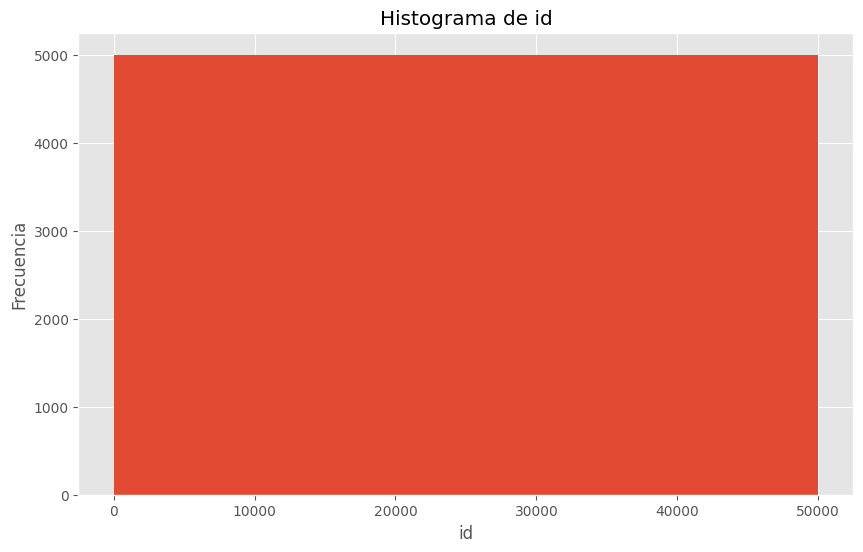

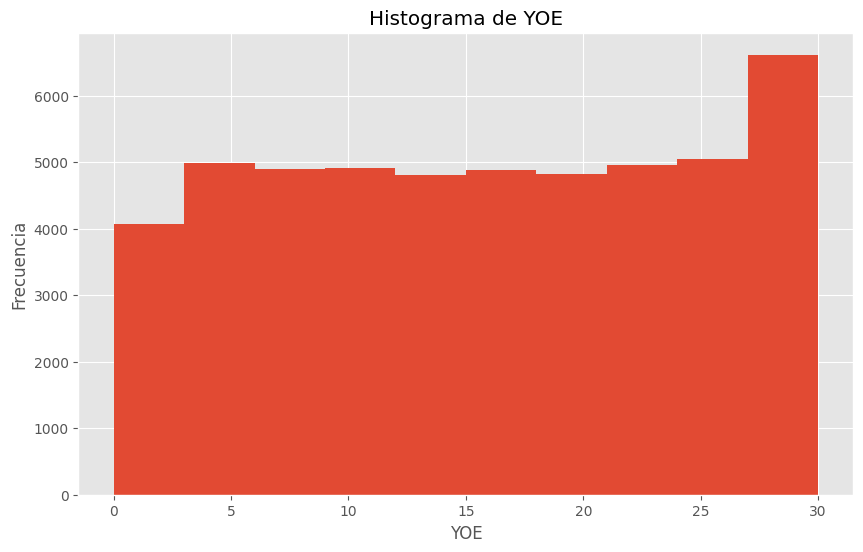

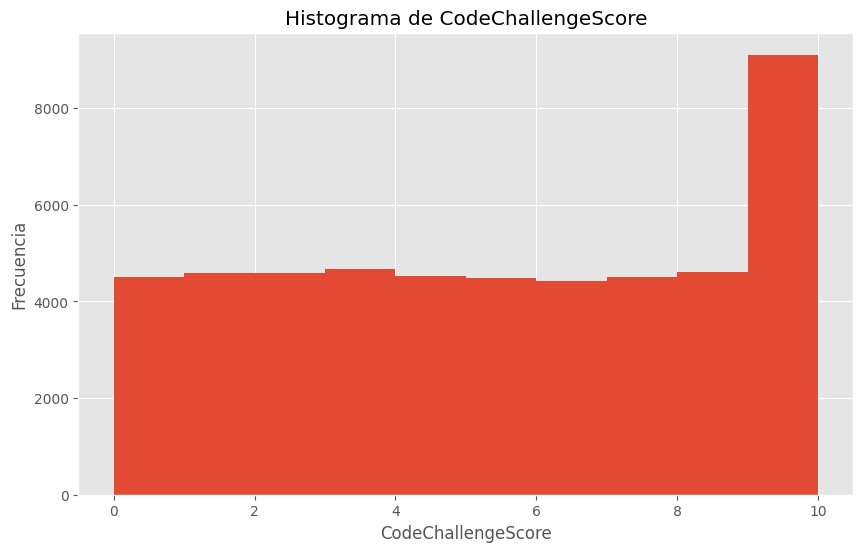

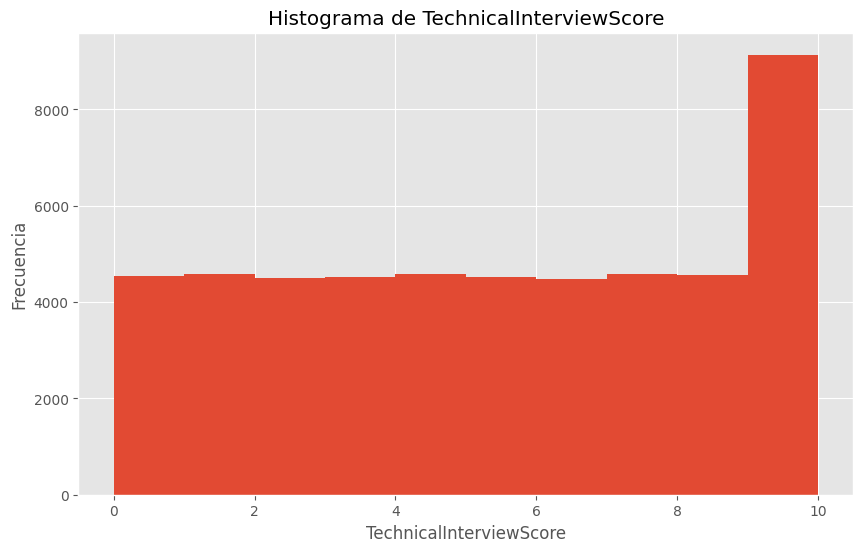

In [22]:
numerical = df.select_dtypes('number')
for column in numerical.columns:
    plt.figure(figsize=(10, 6))
    plt.hist(df[column])
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.show()

The distribution of the numerical values indeed appears to follow a uniform distribution, but with a higher frequency in the last interval. This is why the median used to be slightly higher than the mean.

In [23]:
summary = pd.DataFrame({
    'dtypes': df.dtypes,
    'null count': df.isnull().sum(),
    'duplicate count': df.duplicated().sum(),
    'unique values': df.nunique()
})
summary

,dtypes,null count,duplicate count,unique values
id,int64,0,0,50000
FirstName,object,0,0,3007
LastName,object,0,0,474
Email,object,0,0,49833
ApplicationDate,object,0,0,1646
Country,object,0,0,244
YOE,int64,0,0,31
Seniority,object,0,0,7
Technology,object,0,0,24
CodeChallengeScore,int64,0,0,11


Seniority has 7 categories, which allows us to perform analytics on the different levels of seniority and their variations. We can see that not all email addresses are unique, indicating that some individuals have reapplied. We need to identify who has reapplied and examine any variations in their data. If there are changes in the data for reapplicants, this may indicate a lack of data integrity.


In [24]:
repeat = df['Email'].value_counts()
repeat.sort_values(ascending=False).head()

Email
fern70@gmail.com           3
marianne31@yahoo.com       3
alejandra17@hotmail.com    2
isaiah24@yahoo.com         2
benny35@yahoo.com          2
Name: count, dtype: int64

In [25]:
df.loc[df['Email'] == 'fern70@gmail.com']

,id,FirstName,LastName,Email,ApplicationDate,Country,YOE,Seniority,Technology,CodeChallengeScore,TechnicalInterviewScore
3255,3254,Bobby,Tromp,fern70@gmail.com,2018-06-07,Lesotho,18,Lead,Game Development,6,1
39973,39961,Tiara,Davis,fern70@gmail.com,2018-05-01,Serbia,11,Mid-Level,Development - CMS Frontend,1,0
45750,45749,Favian,Halvorson,fern70@gmail.com,2019-08-22,Kazakhstan,13,Intern,Security,7,0


In this small example, we can see how the data lacks integrity. Different people with the same email address appear for tests on different dates, and the years of experience are also inconsistent.

# 4. Will the numerical data have any correlation?


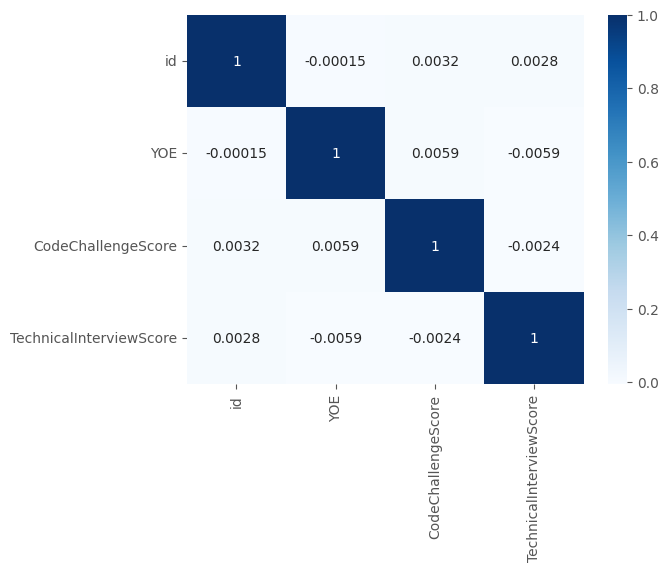

In [26]:
sns.heatmap(df.select_dtypes(int).corr(), annot=True, cmap='Blues')
plt.show()

There is a very weak correlation between the numerical variables, indicating that they are not strongly related to each other, except for hired with the test score's, that have sense because hired in reality its a boleean variable(yes or not), that is calculeted with the both score test. 

In [27]:
seniority = df['Seniority'].value_counts()
seniority

Seniority
Intern       7255
Mid-Level    7253
Trainee      7183
Junior       7100
Architect    7079
Lead         7071
Senior       7059
Name: count, dtype: int64

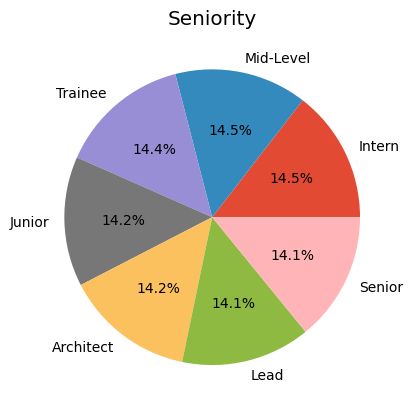

In [28]:
plt.pie(seniority, labels=seniority.index, autopct='%1.1f%%' )
plt.title('Seniority')
plt.show()

The Seniority data maintains a uniform distribution, where all categories have similar percentages.

The ApplicationDate is currently stored as an object type, but it represents a date. We can easily convert it to a date type using Pandas to perform further analysis.

In [30]:
df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'])
df['ApplicationDate'].dt.year.value_counts()


ApplicationDate
2020    11237
2018    11061
2021    11051
2019    11009
2022     5642
Name: count, dtype: int64

The tests were conducted from 2019 to 2022. The data shows that the number of records from 2019 to 2021 is similar, but there are only half as many records in 2022. What happened this year?

In [31]:
df.loc[df['ApplicationDate'].dt.year == 2022]['ApplicationDate'].dt.month.value_counts()

ApplicationDate
5    979
3    962
4    923
1    912
6    910
2    844
7    112
Name: count, dtype: int64

Considering that the months range from month 1 (January) to 12 (December), it seems these records were collected only until month 7 (July). This explains why there are fewer records for this year.

# 5. Insights

Is there a profile with a higher probability of being hired?

In [11]:
df['hired'] = np.where((df['CodeChallengeScore'] >= 7) & (df['TechnicalInterviewScore'] >= 7), 1, 0)

In [12]:
df['hired'].value_counts(normalize = True) * 100

hired
0    86.604
1    13.396
Name: proportion, dtype: float64

Only about 13% of the individuals who took the test were hired. Let's see if there is any profile that is more likely to be hired.

<Axes: xlabel='Seniority'>

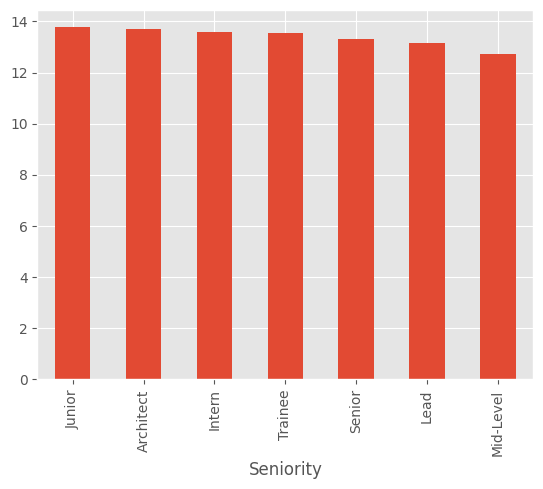

In [34]:
temp = df.groupby('Seniority').hired.mean().sort_values(ascending = False)*100
temp.plot.bar()

It seems that candidates applying for internship positions have a higher probability of being hired.

<Axes: xlabel='Country'>

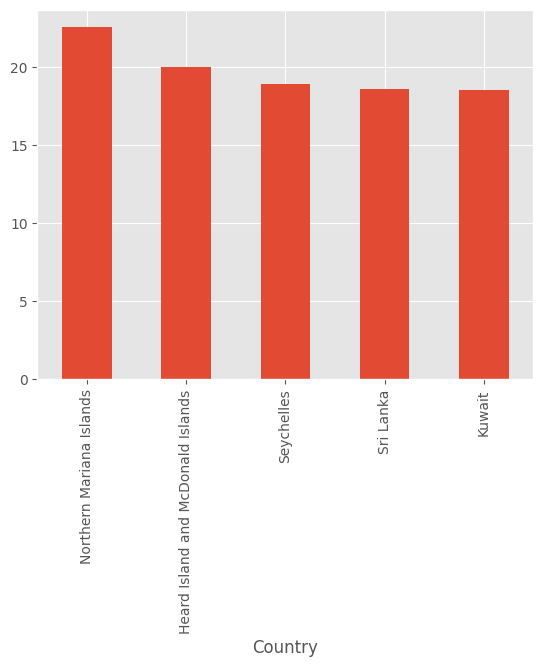

In [35]:
temp = df.groupby('Country').hired.mean().sort_values(ascending = False)*100
temp = temp.head()
temp.plot.bar()

In [36]:
df['Country'].loc[df['hired']==1].value_counts(ascending=False)

Country
Northern Mariana Islands             44
Heard Island and McDonald Islands    41
Sri Lanka                            40
Seychelles                           40
Niger                                40
                                     ..
Canada                               18
Maldives                             16
Saint Vincent and the Grenadines     16
Montenegro                           15
Guam                                 15
Name: count, Length: 244, dtype: int64


It appears that the second country with the highest number of hires is an island I had never heard of. The curious thing is that this island has a population of 0. Where are we finding people from this phantom country? probabily in this datset have many problems like that.

<Axes: xlabel='Technology'>

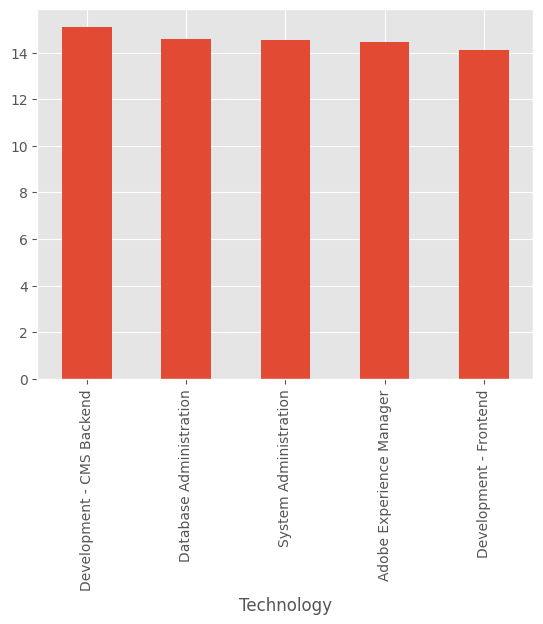

In [37]:
temp = df.groupby('Technology').hired.mean().sort_values(ascending = False)*100
temp = temp.head()
temp.plot.bar()

<Axes: xlabel='year'>

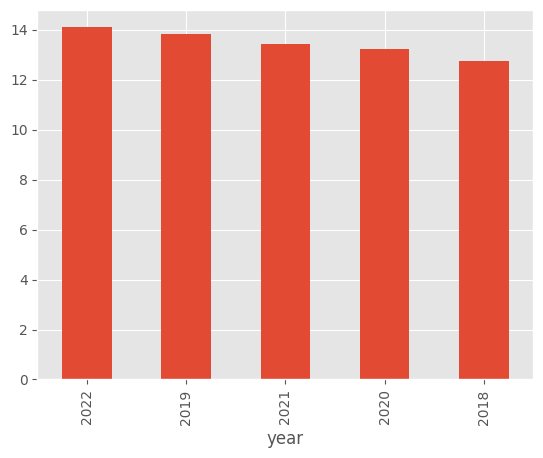

In [39]:
df_copy = df.copy()
df_copy['year'] = df_copy['ApplicationDate'].dt.year
temp = df_copy.groupby('year').hired.mean().sort_values(ascending = False)*100
temp.plot.bar()

# 6. Conclusions




Since the data was generated using simple random methods, it shows low variance in its distribution and has some integrity issues in certain records. Additionally, the relationship between YOE (Years of Experience) and Seniority is null, when theoretically, there should be a stronger relationship.

The numerical data does not seem to have correlations between variables, meaning that the variables are independent of each other.

There are 7 categorical variables for Seniority, which appear to have similar percentages of occurrence.

Only 13% of the 50,000 candidates who took the tests were hired.

The profiles with a higher probability of being hired are:


*   Those who entered as interns

*   Candidates from northern mariana islands or McDonald's Island (a country with no current population)

*   People from the Development - CMS area

*   Candidates who applied in 2022 had a higher chance of being hired


